## Using Facebook's prophet to predict Schiphol passenger numbers

In [8]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib as matplotlib
from fbprophet import Prophet

In [9]:
kblue = [50/256, 87/256, 164/256]
grey = [0.6, 0.6, 0.6]
matplotlib.rcParams.update({'font.size': 16})

In [10]:
months_to_hold_back = 6

### Schiphol passenger number data

In [11]:
schiphol_data = pd.read_csv('./data/schiphol_millions_pax_monthly.csv', index_col = 0)

In [12]:
# make a nice date format for prophet
schiphol_data.index = [datetime.strptime(x, '%b-%Y') for x in schiphol_data.index]

In [13]:
schiphol_data_held_back = schiphol_data[-months_to_hold_back:]
schiphol_data = schiphol_data[:-months_to_hold_back].copy()

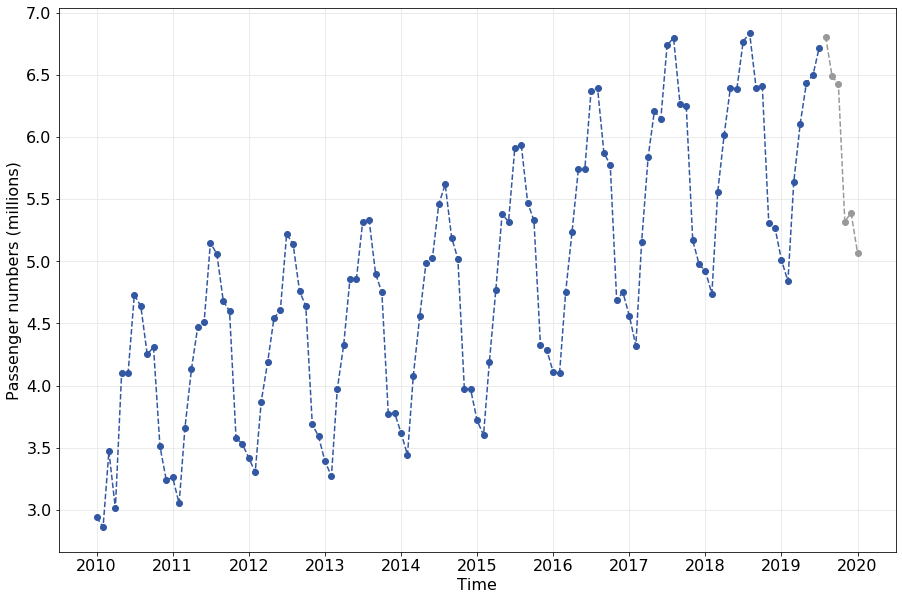

In [14]:
fig, ax = plt.subplots(figsize = [15, 10])
ax.plot(schiphol_data, 'o--', color = kblue)
ax.plot(schiphol_data_held_back, 'o--', color = grey)
ax.set_xlabel('Time')
ax.set_ylabel('Passenger numbers (millions)')
ax.grid(True, color = [0.9, 0.9, 0.9, 0.1])
plt.savefig('./images/schiphol_data.png', bbox_inches = 'tight', dpi = 600)
plt.show()

### Capturing trends and seasonality with prophet

In [15]:
# prophet needs data in a very specific format
proph_df = pd.DataFrame(data = {'ds':schiphol_data.index, 'y': [x[0] for x in schiphol_data.values]})
# fit prophet
m = Prophet(mcmc_samples=300, weekly_seasonality=False, daily_seasonality=False)
m.fit(proph_df)

In [16]:
forecast = m.predict(proph_df)

In [17]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-01-01,3.669435,2.601541,2.964987,3.594596,3.747118,-0.892006,-0.956912,-0.830655,-0.892006,-0.956912,-0.830655,0.0,0.0,0.0,2.777428
1,2010-02-01,3.696343,2.459956,2.797451,3.627760,3.770175,-1.071165,-1.138284,-1.005992,-1.071165,-1.138284,-1.005992,0.0,0.0,0.0,2.625178
2,2010-03-01,3.720646,3.139420,3.499156,3.653886,3.789417,-0.406163,-0.465667,-0.346220,-0.406163,-0.465667,-0.346220,0.0,0.0,0.0,3.314483
3,2010-04-01,3.747554,3.524423,3.885687,3.685344,3.809686,-0.039197,-0.094399,0.015346,-0.039197,-0.094399,0.015346,0.0,0.0,0.0,3.708357
4,2010-05-01,3.773594,4.031877,4.384710,3.715057,3.832692,0.440617,0.379636,0.503468,0.440617,0.379636,0.503468,0.0,0.0,0.0,4.214211


In [18]:
proph_df_plus_pred = pd.merge(proph_df.set_index('ds'), forecast.set_index('ds'), left_index=True, right_index=True).reset_index()
proph_df_plus_pred['y_m_trend'] = proph_df_plus_pred['y']-proph_df_plus_pred['trend']

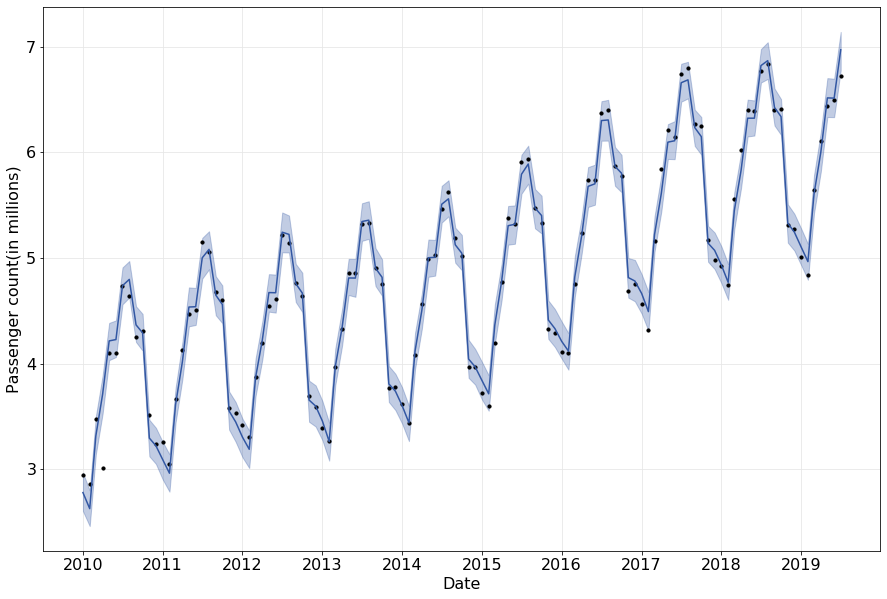

In [19]:
fig, ax = plt.subplots(figsize = [15, 10])
ax.set_axisbelow(True)
ax.grid(True, color = [0.9, 0.9, 0.9, 0.1])
ax.fill_between(proph_df_plus_pred['ds'], proph_df_plus_pred['yhat_lower'], proph_df_plus_pred['yhat_upper'], color = kblue, alpha = 0.3)
ax.plot(proph_df_plus_pred['ds'], proph_df_plus_pred['yhat'], color = kblue)
ax.scatter(proph_df_plus_pred['ds'], proph_df_plus_pred['y'], color = 'k', s = 10)
ax.set_xlabel('Date')
ax.set_ylabel('Passenger count(in millions)')
plt.savefig('./images/schiphol_data_fit.png', bbox_inches = 'tight', dpi = 600)
plt.show()

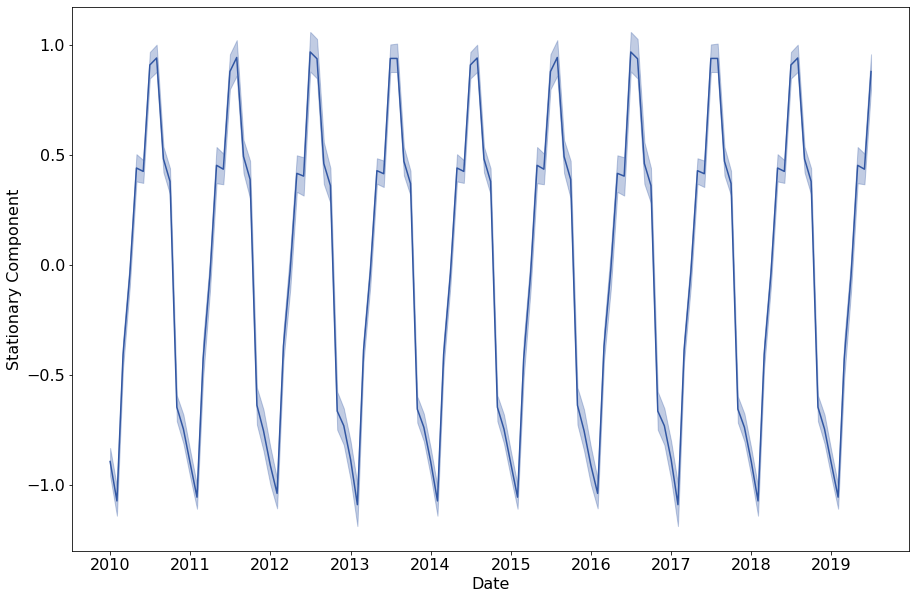

In [20]:
fig, ax = plt.subplots(figsize = [15, 10])
ax.fill_between(proph_df_plus_pred['ds'], proph_df_plus_pred['yearly_lower'], proph_df_plus_pred['yearly_upper'], color = kblue, alpha = 0.3)
ax.plot(proph_df_plus_pred['ds'], proph_df_plus_pred['yearly'], color = kblue)
ax.set_xlabel('Date')
ax.set_ylabel('Stationary Component')
plt.savefig('./images/schiphol_data_stationary.png', bbox_inches = 'tight', dpi = 600)
plt.show()

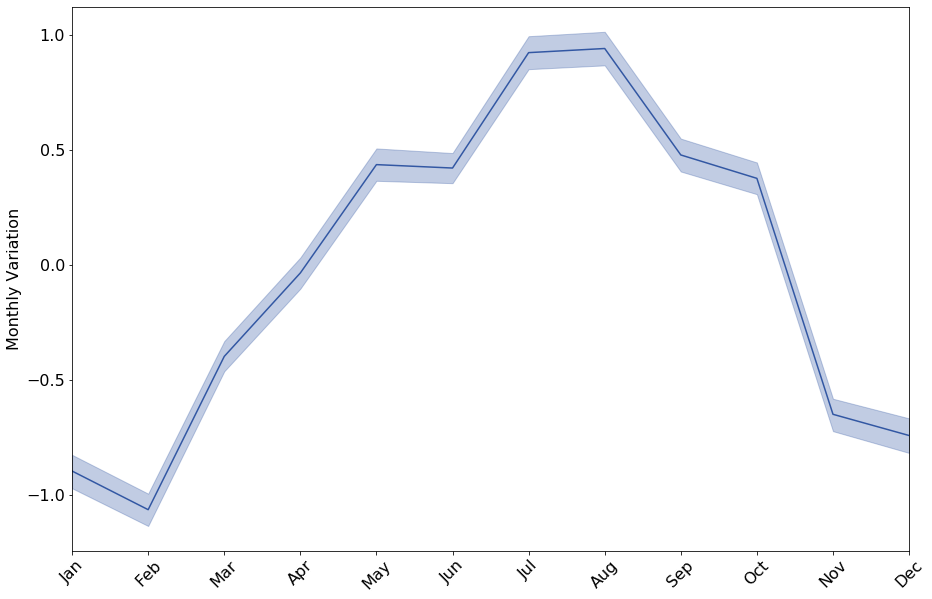

In [21]:
# Stationary Yearly 
yearly_pattern = proph_df_plus_pred['yearly'][:int(12*np.floor(len(proph_df_plus_pred)/12))].values
yearly_pattern_lower = proph_df_plus_pred['yearly_lower'][:int(12*np.floor(len(proph_df_plus_pred)/12))].values
yearly_pattern_upper = proph_df_plus_pred['yearly_upper'][:int(12*np.floor(len(proph_df_plus_pred)/12))].values
single_year = np.mean(yearly_pattern.reshape(int(len(yearly_pattern)/12),12), axis = 0)
single_year_lower = np.mean(yearly_pattern_lower.reshape(int(len(yearly_pattern)/12),12), axis = 0)
single_year_upper = np.mean(yearly_pattern_upper.reshape(int(len(yearly_pattern)/12),12), axis = 0)
single_year_std = np.std(yearly_pattern.reshape(int(len(yearly_pattern)/12),12), axis = 0)

fig, ax = plt.subplots(figsize = [15, 10])
month_array = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax.fill_between(np.arange(0,len(month_array)), single_year_lower, single_year_upper, color = kblue, alpha = 0.3)
ax.plot(np.arange(0,len(month_array)), single_year,color = kblue)
ax.set_xticks(np.arange(0,len(month_array)))
ax.set_xticklabels(month_array, rotation = 45)
ax.set_ylabel('Monthly Variation')
ax.set_xlim(0, len(month_array)-1)
plt.savefig('./images/schiphol_data_monthly_variation.png', bbox_inches = 'tight', dpi = 600)
plt.show()

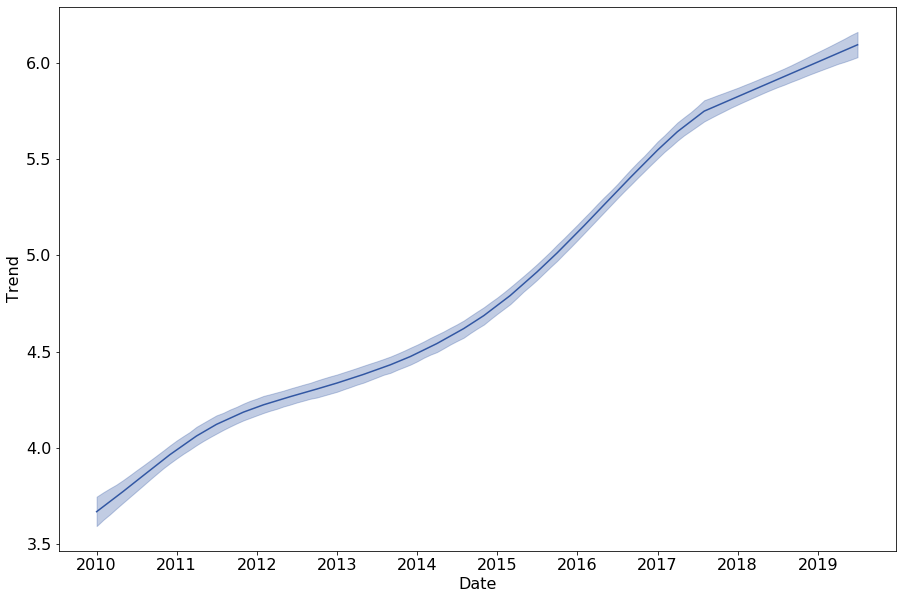

In [22]:
fig, ax = plt.subplots(figsize = [15, 10])
ax.fill_between(proph_df_plus_pred['ds'], proph_df_plus_pred['trend_lower'], proph_df_plus_pred['trend_upper'], color = kblue, alpha = 0.3)
ax.plot(proph_df_plus_pred['ds'], proph_df_plus_pred['trend'], color = kblue)
ax.set_xlabel('Date')
ax.set_ylabel('Trend')
plt.savefig('./images/schiphol_data_trend.png', bbox_inches = 'tight', dpi = 600)
plt.show()

### Predicting next n-months

In [23]:
# prophet needs data in a very specific format
proph_held_back_df = pd.DataFrame(data = {'ds':schiphol_data_held_back.index, 'y': [x[0] for x in schiphol_data_held_back.values]})
# forecast
forecast_held_back = m.predict(proph_held_back_df)
# add real data to forecast
proph_held_back_df_plus_pred = pd.merge(proph_held_back_df.set_index('ds'), forecast_held_back.set_index('ds'), left_index=True, right_index=True).reset_index()
# calculate rmse
rmse = np.sqrt(np.sum((proph_held_back_df_plus_pred['yhat'].values-proph_held_back_df_plus_pred['y'].values)**2))/np.sqrt(len(proph_held_back_df_plus_pred))

In [24]:
proph_held_back_df_plus_pred

,ds,y,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-08-01,6.81,6.108410,6.864753,7.251198,6.040879,6.179216,0.942670,0.859731,1.021330,0.942670,0.859731,1.021330,0.0,0.0,0.0,7.051080
1,2019-09-01,6.49,6.123690,6.430263,6.806056,6.054346,6.198425,0.492859,0.417313,0.567617,0.492859,0.417313,0.567617,0.0,0.0,0.0,6.616549
2,2019-10-01,6.43,6.138477,6.332481,6.722233,6.064986,6.216859,0.388946,0.302386,0.473067,0.388946,0.302386,0.473067,0.0,0.0,0.0,6.527422
3,2019-11-01,5.32,6.153757,5.325588,5.717392,6.075637,6.236921,-0.636580,-0.724446,-0.556771,-0.636580,-0.724446,-0.556771,0.0,0.0,0.0,5.517177
4,2019-12-01,5.39,6.168543,5.213621,5.626839,6.084934,6.256432,-0.752207,-0.843034,-0.656166,-0.752207,-0.843034,-0.656166,0.0,0.0,0.0,5.416337
5,2020-01-01,5.07,6.183823,5.081619,5.473707,6.093896,6.276110,-0.908673,-0.995657,-0.825065,-0.908673,-0.995657,-0.825065,0.0,0.0,0.0,5.275150


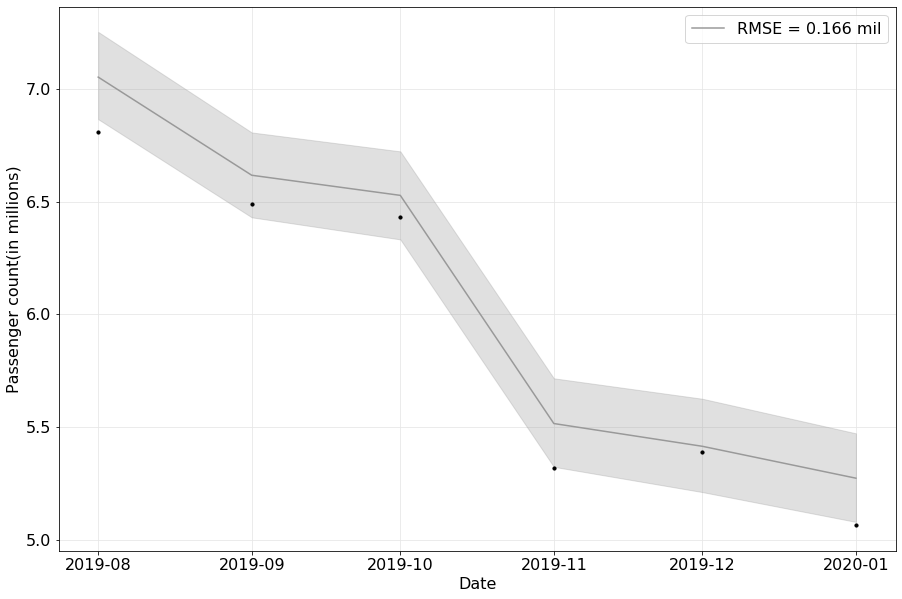

In [25]:
fig, ax = plt.subplots(figsize = [15, 10])
ax.set_axisbelow(True)
ax.grid(True, color = [0.9, 0.9, 0.9, 0.1])
ax.fill_between(proph_held_back_df_plus_pred['ds'], proph_held_back_df_plus_pred['yhat_lower'], proph_held_back_df_plus_pred['yhat_upper'], color = grey, alpha = 0.3)
ax.plot(proph_held_back_df_plus_pred['ds'], proph_held_back_df_plus_pred['yhat'], color = grey, label = 'RMSE = {:.3f} mil'.format(rmse))
ax.scatter(proph_held_back_df_plus_pred['ds'], proph_held_back_df_plus_pred['y'], color = 'k', s = 10)
ax.set_xlabel('Date')
ax.set_ylabel('Passenger count(in millions)')
plt.savefig('./images/schiphol_data_fit_held_back.png', bbox_inches = 'tight', dpi = 600)
plt.legend()
plt.show()

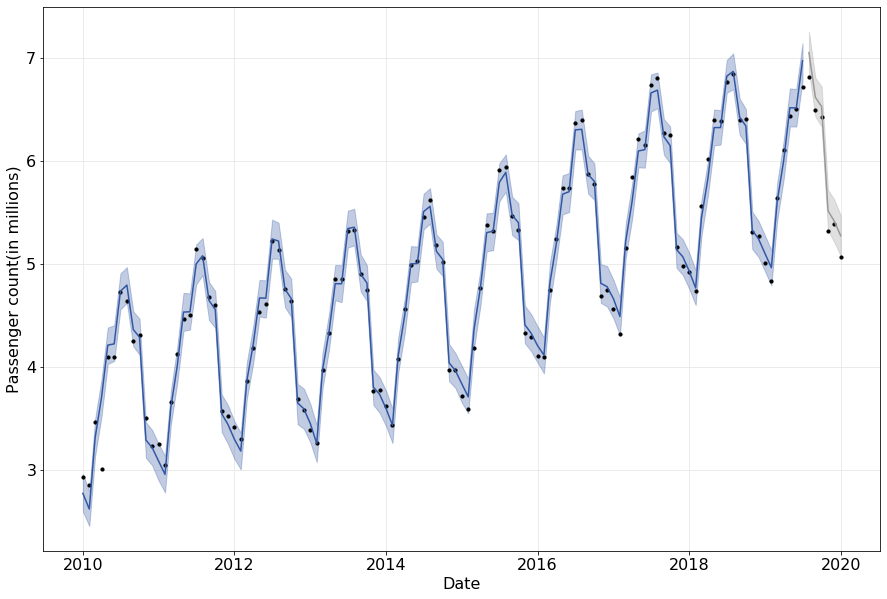

In [26]:
fig, ax = plt.subplots(figsize = [15, 10])
ax.set_axisbelow(True)
ax.grid(True, color = [0.9, 0.9, 0.9, 0.1])
ax.fill_between(proph_df_plus_pred['ds'], proph_df_plus_pred['yhat_lower'], proph_df_plus_pred['yhat_upper'], color = kblue, alpha = 0.3)
ax.plot(proph_df_plus_pred['ds'], proph_df_plus_pred['yhat'], color = kblue)
ax.scatter(proph_df_plus_pred['ds'], proph_df_plus_pred['y'], color = 'k', s = 10)
ax.fill_between(proph_held_back_df_plus_pred['ds'], proph_held_back_df_plus_pred['yhat_lower'], proph_held_back_df_plus_pred['yhat_upper'], color = grey, alpha = 0.3)
ax.plot(proph_held_back_df_plus_pred['ds'], proph_held_back_df_plus_pred['yhat'], color = grey, label = 'RMSE = {:.3f} mil'.format(rmse))
ax.scatter(proph_held_back_df_plus_pred['ds'], proph_held_back_df_plus_pred['y'], color = 'k', s = 10)
ax.set_xlabel('Date')
ax.set_ylabel('Passenger count(in millions)')
plt.savefig('./images/schiphol_data_fit_held_back_plus_orig.png', bbox_inches = 'tight', dpi = 600)
plt.show()